In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [117]:
class ResidualBlock(nn.Module):
    def __init__(self, dimension, num_layers, activation):
        super(ResidualBlock, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(nn.Linear(dimension, dimension))
            self.layers.append(activation)

    def forward(self, x):
        residual = x
        for layer in self.layers:
            x = layer(x)
        return x + residual
        
class Autoencoder(nn.Module):
    def __init__(self, dimension, num_blocks, num_layers, activations, noise):
        super(Autoencoder, self).__init__()
        encoder_activation, decoder_activation = activations
        self.encoder = nn.Sequential(
            nn.Linear(2, dimension),
            *[ResidualBlock(dimension, num_layers, encoder_activation) for _ in range(num_blocks)],
            nn.Linear(dimension, 1)
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, dimension),
            *[ResidualBlock(dimension, num_layers, decoder_activation) for _ in range(num_blocks)],
            nn.Linear(dimension, 2)
        )

    def forward(self, x):
        latent = self.encoder(x)
        latent += torch.normal(0, noise, size=latent.shape, device=latent.device)
        reconstructed = self.decoder(latent)
        return reconstructed

In [9]:
def generate_points(grid_size, randomize=False):
    spacing = 1 / (grid_size - 1) * 2
    
    # Generate evenly spaced grid points
    x = np.linspace(-1 + spacing / 2, 1 - spacing / 2, grid_size)
    y = np.linspace(-1 + spacing / 2, 1 - spacing / 2, grid_size)
    grid_points = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)

    # Generate perturbations
    if randomize:
        perturbations = np.random.uniform(-spacing/2, spacing/2, size=(grid_size**2, 2))
    else:
        perturbations = np.zeros(shape=(grid_size**2, 2))
    
    # Add perturbations to the grid points
    perturbed_points = grid_points + perturbations
    perturbed_points_tensor = torch.from_numpy(perturbed_points).float()   
    return perturbed_points_tensor

In [138]:
# Training parameters
def train_autoencoder(model, iterations, grid_size, lr1, lr2, weight_decay, scheduler_params, schedule='exp', device='cpu'):
    if schedule == 'exp':
        gamma = scheduler_params["gamma"]
    elif schedule == 'cos':
        min_lr_factor = scheduler_params["min_lr_factor"]
        min_lr1, min_lr2 = lr1 / min_lr_factor, lr2 / min_lr_factor
        
        if iterations != 1:
            decrement1, decrement2 = (lr1 - min_lr1) / (iterations - 1), (lr2 - min_lr2) / (iterations - 1)
        else: 
            decrement1 = decrement2 = 0
        
        T_0, T_mult, eta_min = scheduler_params["T_0"], scheduler_params["T_mult"], scheduler_params["eta_min"]

    # turn "iterations" into actual epochs. only needed for cosine annealing right now
    epochs = iterations
    if schedule == 'cos':
        # calculate the total number of epochs needed to reach the end of the last cycle
        epochs = int(T_0 * (1 - T_mult ** (iterations)) / (1 - T_mult)) if T_mult != 1 else T_0 * iterations
    
    lr_list = []
    loss_list = []
    
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer1 = optim.Adam(model.encoder.parameters(), lr=lr1, betas=(0.9, 0.9))
    optimizer2 = optim.Adam(model.decoder.parameters(), lr=lr2, betas=(0.9, 0.9), weight_decay=weight_decay)

    if schedule == 'cos':
        scheduler1 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer1, T_0=T_0, T_mult=T_mult, eta_min=eta_min)
        scheduler2 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer2, T_0=T_0, T_mult=T_mult, eta_min=eta_min)
    elif schedule == 'exp':
        scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer1, gamma)
        scheduler2 = optim.lr_scheduler.ExponentialLR(optimizer2, gamma)
    elif schedule == 'lin':
        scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer1, 1.0, 0, epochs)       
        scheduler2 = torch.optim.lr_scheduler.LinearLR(optimizer2, 1.0, 0, epochs)

    for epoch in range(epochs):
        train_data = generate_points(grid_size).to(device)
        reconstructed_data = model(train_data)
        loss = criterion(reconstructed_data, train_data)

        if schedule is not None:
            lr_list.append(scheduler1.get_last_lr()[0])
        loss_list.append(loss.item())
        
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        loss.backward()
        optimizer1.step()
        optimizer2.step()

        if schedule == 'cos' and (scheduler2.T_cur + 1) == scheduler2.T_i:
            scheduler1.base_lrs = [lr - decrement1 for lr in scheduler1.base_lrs]
            scheduler2.base_lrs = [lr - decrement2 for lr in scheduler2.base_lrs]
        if schedule is not None:
            scheduler1.step()
            scheduler2.step()

        if (epoch + 1) % (epochs // 10) == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.5f}")
        

    return model, lr_list, loss_list


In [144]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

activations = {
    #'ReLU ReLU': [nn.ReLU(), nn.ReLU()]
    'ReLU GELU': [nn.ReLU(), nn.GELU()]
    #'ReLU Sigmoid': [nn.ReLU(), nn.Sigmoid()]
}

dim, blocks, layers = 256, 4, 4

models = {}
loss_lists = {}

for activation_name, activation_fn in activations.items():
    noise = 0.00
    model = Autoencoder(dim, blocks, layers, activation_fn, noise)
    grid_size = 32
    weight_decay = 1e-8 # only used for decoder

    # this is kinda gross but when iters=1, T_0 is epochs. turns cosine w/ restarts into just cosine so i dont need to add an extra case :^)
    cos_scheduler_params = {'iters': 1, 'lr1': 0.0001, 'lr2': 0.01, 'T_0': 50000, 'T_mult': 1, 'eta_min': 0, 'min_lr_factor': 1}  
    exp_scheduler_params = {'iters': 6000, 'lr1': 0.0001, 'lr2': 0.001, 'gamma': 1 - 9e-4} 
    lin_scheduler_params = {'iters': 24000, 'lr1': 0.0001, 'lr2': 0.01} # LOSS: 0.00091 (ReLU GELU)

    scheduler = cos_scheduler_params
    iters, lr1, lr2 = scheduler['iters'], scheduler['lr1'], scheduler['lr2']
    
    print(f"Training with {activation_name} activation")
    model, lr_list, loss_list = train_autoencoder(model, iters, grid_size, lr1, lr2, weight_decay, scheduler, 'cos', device)
    models[activation_name] = model
    loss_lists[activation_name] = loss_list

cuda
Training with ReLU ReLU activation
Epoch [5000/50000], Loss: 0.00890
Epoch [10000/50000], Loss: 0.00565
Epoch [15000/50000], Loss: 0.00346
Epoch [20000/50000], Loss: 0.00267
Epoch [25000/50000], Loss: 0.00242
Epoch [30000/50000], Loss: 0.00164
Epoch [35000/50000], Loss: 0.00093
Epoch [40000/50000], Loss: 0.00068
Epoch [45000/50000], Loss: 0.00052
Epoch [50000/50000], Loss: 0.00049


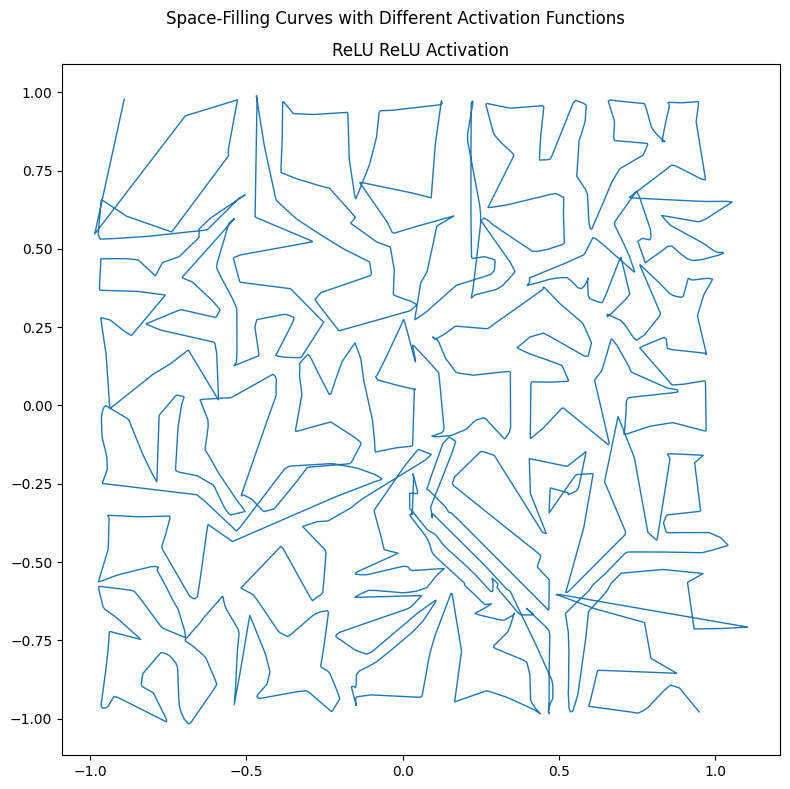

In [145]:
fig, axs = plt.subplots(1, len(activations), figsize=(8, 8))
if len(activations) == 1:
    axs = [axs]
    
fig.suptitle("Space-Filling Curves with Different Activation Functions")

def get_curve_points(model):
    grid = generate_points(32).cuda()
    
    with torch.no_grad():
        z = model.encoder(grid)
        min_val = z.min().item()
        max_val = z.max().item()
        num_points = int(1e4)
        z = torch.linspace(min_val, max_val, num_points).reshape(-1, 1).cuda()
        curve_points = model.decoder(z).cpu()
        
    return curve_points

for i, (activation_name, activation_fn) in enumerate(activations.items()):
    model = models[activation_name]
    curve_points = get_curve_points(model)

    # Plot the space-filling curve
    axs[i].plot(curve_points[:, 0], curve_points[:, 1], linewidth=1, markersize=1)
    
    # uncomment these two if there's wacky offshoots way outside of the box
    #axs[i].set_xlim(-1, 1)
    #axs[i].set_ylim(-1, 1)
    axs[i].set_title(f"{activation_name} Activation")

plt.tight_layout()
plt.show()

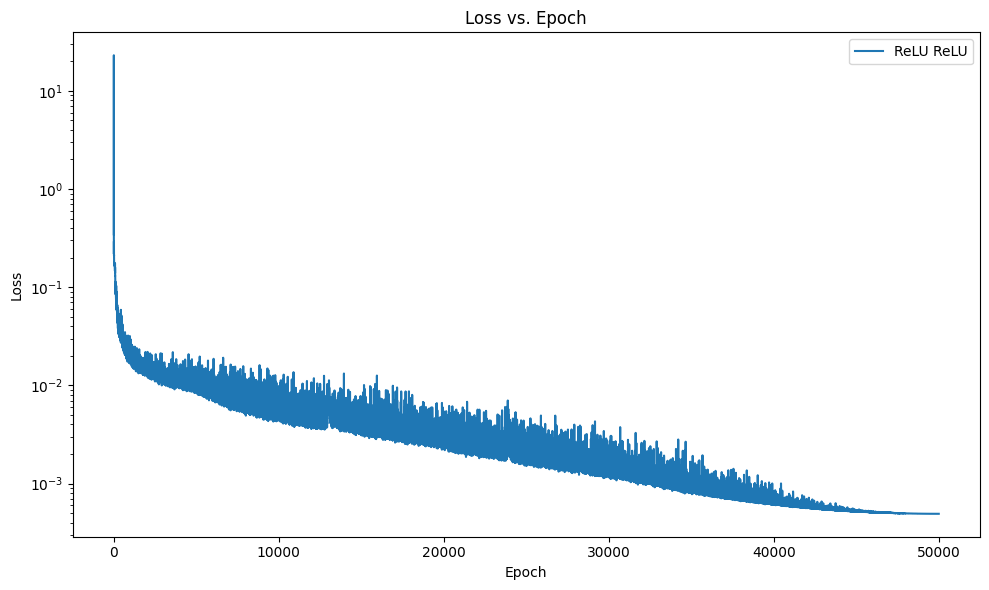

In [147]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_yscale('log')
for activation_name, loss_list in loss_lists.items():
    ax.plot(range(1, len(loss_list) + 1), loss_list, label=activation_name)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss vs. Epoch")
ax.legend()

plt.tight_layout()
plt.show()

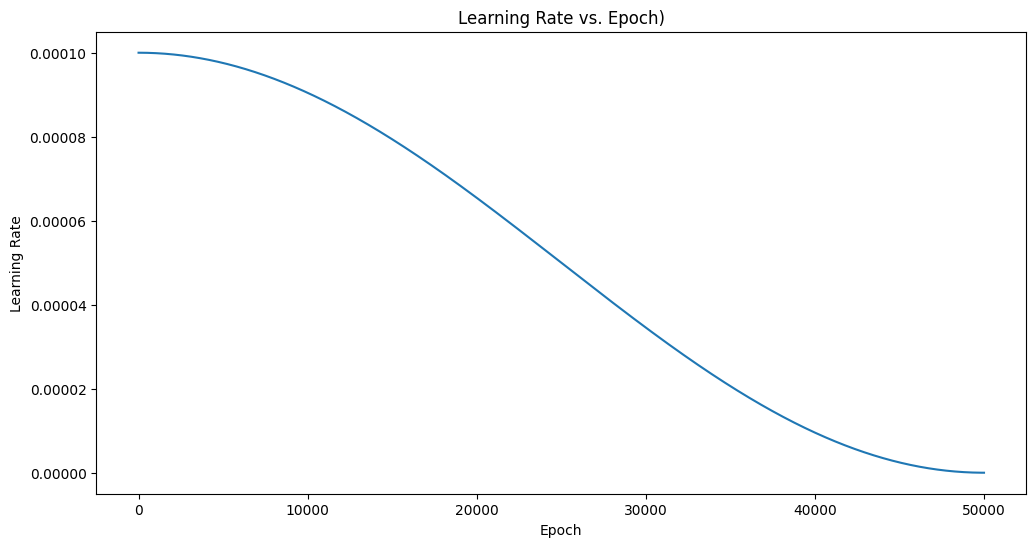

In [146]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(0, len(lr_list)), lr_list)
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")
ax.set_title(f"Learning Rate vs. Epoch)")
plt.show()